# 02. Neural Network classification with PyTorch


In [1]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

In [2]:
print(f"First 5 samples of X:\n{X[:5]}")
print(f"First 5 samples of y:\n{y[:5]}")

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [3]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


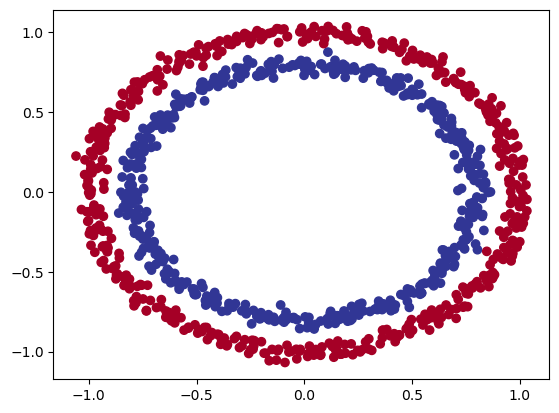

In [4]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

## 1.1 Check input and output shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X:{X_sample} and the same for y: {y_sample}")
print(
    f"Shape for one sample of X:{X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X:[0.75424625 0.23148074] and the same for y: 1
Shape for one sample of X:(2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [7]:
import torch

torch.__version__

'2.1.0.post3'

In [8]:
type(X)

numpy.ndarray

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 2. Building a model
Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by sub-classing `nn.Module`)
* 2.1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
* 2.2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
* 2.3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
* 2.4. Instantiate an instance of our model class and send it ot the target `device`
3. Define a loss function and optimizer
4. Create a training and test loop


In [11]:
# Import PyTorch and nn
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
X_train.shape[1]

2

In [13]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    INPUT_ZERO = X_train.shape[1]

    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our date
        # takes in 2 features and up-scales to 5 features
        self.layer_01 = nn.Linear(in_features=self.INPUT_ZERO, out_features=5)
        self.layer_02 = nn.Linear(in_features=5, out_features=1)

    # 3. define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_02(self.layer_01(x))  # x -> layer_1 -> layer_2


# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer_01): Linear(in_features=2, out_features=5, bias=True)
  (layer_02): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5), nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
model_0.state_dict().keys()

odict_keys(['0.weight', '0.bias', '1.weight', '1.bias'])

In [16]:
# make predictions
with torch.inference_mode():
    untrained_pred = model_0(X_test.to(device))
print(
    f" Length of predictions: {len(untrained_pred)} *** Shape: {untrained_pred.shape}")
print(f" Length of predictions: {len(X_test)} *** Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_pred[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

 Length of predictions: 200 *** Shape: torch.Size([200, 1])
 Length of predictions: 200 *** Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[ 0.2534],
        [ 0.2298],
        [ 0.0110],
        [ 0.3234],
        [-0.4722],
        [-0.4829],
        [-0.1665],
        [-0.3347],
        [ 0.0318],
        [ 0.2228]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?
Again... this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error)
For classification you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measures how **wrong** your models predictions are.
And for optimizers, two of the most common and useful are SGD and Adam, 
however Pytorch has many built-in options.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`, for more on what binary cross entropy (BCE) is.


In [17]:
# setup loss function

# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# BCEWithLogitsLoss = sigmoid activation function built-in
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=.1)

In [18]:
# calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_pred)) * 100

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass 
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.
We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification) 


In [19]:
# view the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[ 0.2534],
        [ 0.2298],
        [ 0.0110],
        [ 0.3234],
        [-0.4722]])

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [21]:
# use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5630],
        [0.5572],
        [0.5028],
        [0.5801],
        [0.3841]])

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` **(class 1)**
* `y_pred_probs` < 0.5, `y=0` **(class 0)**

In [22]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.])

### 3.2 Building a training and testing loop


In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 200
# Put data to data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    # tur logits -> pred probs -> pred labels
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/acc
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #               y_train)
    loss = loss_fn(y_logits,  # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    # Print out what's happening
    if epoch % 10 == 0:
        print(
            (f"Epoch: {epoch:04d} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"))

Epoch: 0000 | Loss: 0.70417, Acc: 49.12% | Test loss: 0.70717, Test acc: 51.50%
Epoch: 0010 | Loss: 0.70027, Acc: 49.12% | Test loss: 0.70383, Test acc: 51.50%
Epoch: 0020 | Loss: 0.69834, Acc: 50.12% | Test loss: 0.70195, Test acc: 50.00%
Epoch: 0030 | Loss: 0.69715, Acc: 50.62% | Test loss: 0.70063, Test acc: 50.00%
Epoch: 0040 | Loss: 0.69632, Acc: 50.62% | Test loss: 0.69960, Test acc: 50.00%
Epoch: 0050 | Loss: 0.69570, Acc: 50.62% | Test loss: 0.69876, Test acc: 49.50%
Epoch: 0060 | Loss: 0.69521, Acc: 50.62% | Test loss: 0.69807, Test acc: 49.50%
Epoch: 0070 | Loss: 0.69482, Acc: 50.50% | Test loss: 0.69750, Test acc: 50.00%
Epoch: 0080 | Loss: 0.69450, Acc: 50.75% | Test loss: 0.69703, Test acc: 50.00%
Epoch: 0090 | Loss: 0.69424, Acc: 50.50% | Test loss: 0.69663, Test acc: 49.50%
Epoch: 0100 | Loss: 0.69403, Acc: 50.88% | Test loss: 0.69630, Test acc: 49.50%
Epoch: 0110 | Loss: 0.69386, Acc: 51.00% | Test loss: 0.69603, Test acc: 49.50%
Epoch: 0120 | Loss: 0.69372, Acc: 51.00%

## 4. Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything...
So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plot_decision_boundary()` -

In [24]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo ()
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


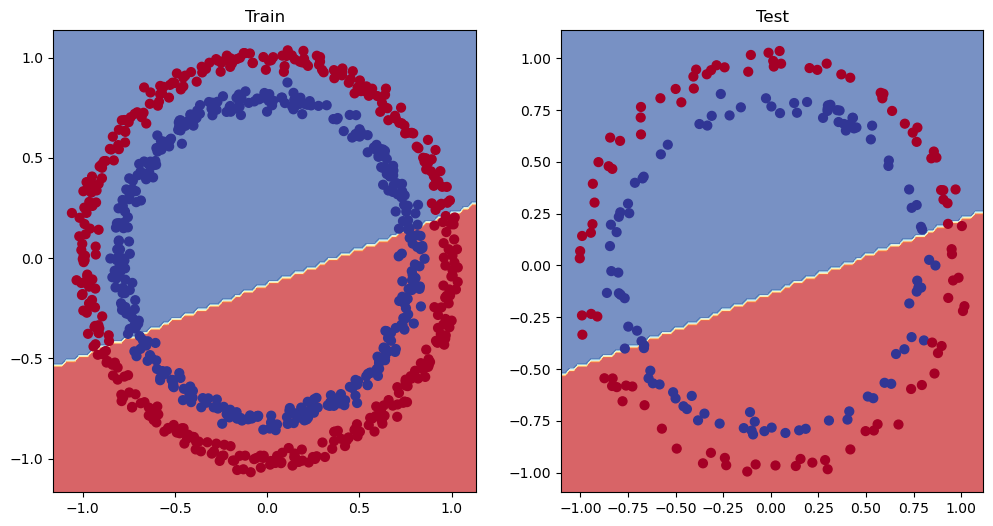

In [25]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model perspective)

* Add more layers-give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units 
* Fit for longer
* Changing the activation functions
* Changing the learning rate
* Changing the loss function

These options are all from a model's perspective because they deal directly with the model,
rather than the data.

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [26]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(
            self.layer_2(
                self.layer_1(x)
            )
        )

In [27]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [28]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=.1)

In [29]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1_000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    """Training"""
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> predicts 
    # 2. Calculate the loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Optimizer step (gradient descent)
    model_1.eval()

    """Testing"""
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss

    if epoch % 100 == 0:
        print(
            (f"Epoch: {epoch:04d} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%"))

Epoch: 0000 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0100 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0200 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0300 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0400 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0500 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0600 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0700 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0800 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%
Epoch: 0900 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69490, Test acc: 49.50%


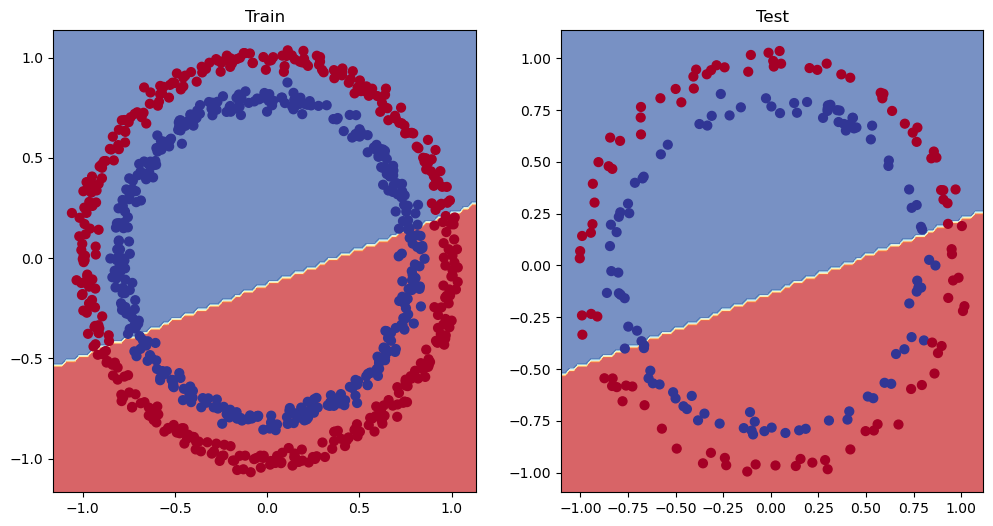

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a large problem is to test out a smaller problem.

In [31]:
# create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

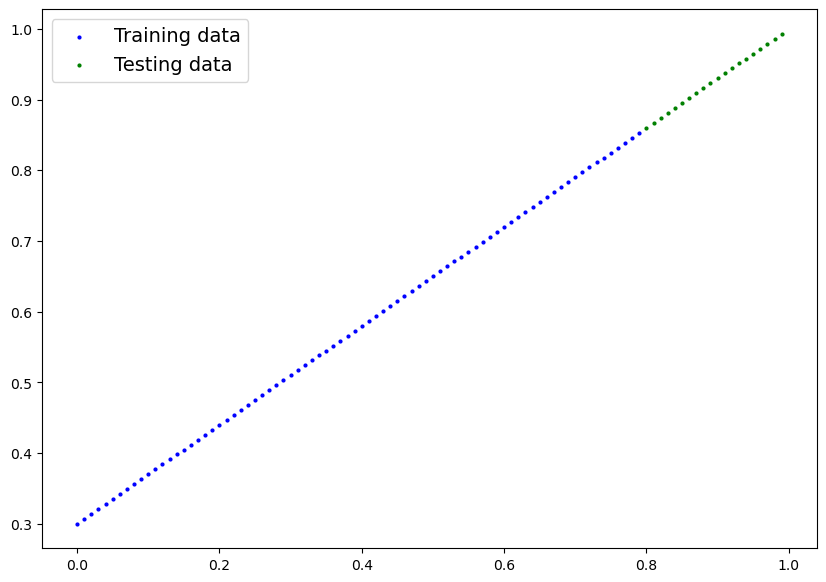

In [40]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit straight line

In [34]:
# same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
).to(device=device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [48]:
# Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.001)


In [49]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs 
epochs = 1000

# Put the data on the target device 
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training 
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:04d} | Loss: {loss:.5f}| Test loss: {test_loss:.5f}")

Epoch: 0000 | Loss: 0.00624| Test loss: 0.01223
Epoch: 0100 | Loss: 0.00041| Test loss: 0.00073
Epoch: 0200 | Loss: 0.00041| Test loss: 0.00081
Epoch: 0300 | Loss: 0.00041| Test loss: 0.00089
Epoch: 0400 | Loss: 0.00041| Test loss: 0.00097
Epoch: 0500 | Loss: 0.00040| Test loss: 0.00106
Epoch: 0600 | Loss: 0.00040| Test loss: 0.00114
Epoch: 0700 | Loss: 0.00040| Test loss: 0.00122
Epoch: 0800 | Loss: 0.00040| Test loss: 0.00130
Epoch: 0900 | Loss: 0.00040| Test loss: 0.00138


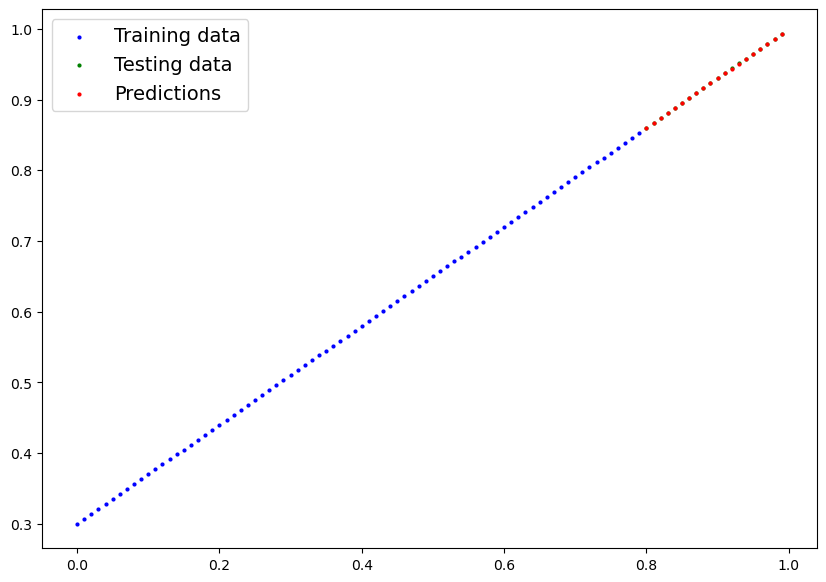

In [50]:
# turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds)